
# Frozen Evaluation Notebook

This notebook provides a structured environment for evaluating the **Frozen** multimodal.
It is designed to:
1.  **Load the model once** to save time.
2.  **Visualize inputs and outputs** clearly.
3.  **Isolate test cases** (Zero-Shot, Few-Shot, Knowledge, Concept Binding) into individual cells for easy iteration.


In [26]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from PIL import Image
from dataclasses import dataclass
from typing import List, Union
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import textwrap
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


In [27]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}")

Running on cuda


In [28]:
@dataclass
class FrozenConfig:
    vision_encoder_name: str = "resnet50"
    language_model_name: str = "gpt2-large"
    visual_prefix_length: int = 2
    vision_hidden_dim: int = 2048
    lm_hidden_dim: int = 1280

class VisionEncoder(nn.Module):
    def __init__(self, config: FrozenConfig):
        super().__init__()
        self.config = config
        # Create backbone (ResNet50 by default)
        self.backbone = timm.create_model(
            config.vision_encoder_name, pretrained=True, num_classes=0, global_pool=''
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        # Projects vision features to the dimension of the LM embeddings
        self.projection = nn.Linear(config.vision_hidden_dim, config.visual_prefix_length * config.lm_hidden_dim)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        features = self.backbone(images)
        features = self.pool(features).flatten(1)
        prefix = self.projection(features)
        # Reshape to [Batch, Prefix_Length, LM_Dim]
        return prefix.view(-1, self.config.visual_prefix_length, self.config.lm_hidden_dim)

class FrozenModel(nn.Module):
    def __init__(self, config: FrozenConfig):
        super().__init__()
        self.config = config
        self.vision_encoder = VisionEncoder(config)
        self.language_model = GPT2LMHeadModel.from_pretrained(config.language_model_name)

    def get_input_embeddings(self):
        return self.language_model.get_input_embeddings()


In [29]:
def generate_from_interleaved(
    model: FrozenModel,
    tokenizer: GPT2Tokenizer,
    prompt_items: List[Union[str, Image.Image]],
    max_new_tokens: int = 20,
    temperature: float = 0.0, 
    device: str = DEVICE
) -> str:
    # Generates text from a sequence of images and text.
    # Stops generation when a newline or new 'Question:' marker is found.
    
    # Standard ImageNet Normalization
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    embeddings_list = []
    
    with torch.no_grad():
        # 1. Build the interleaved embedding sequence
        for item in prompt_items:
            if isinstance(item, Image.Image):
                # Process Image -> Visual Prefix
                img_tensor = transform(item).unsqueeze(0).to(device)
                visual_prefix = model.vision_encoder(img_tensor)
                embeddings_list.append(visual_prefix)
            elif isinstance(item, str):
                # Process Text -> Token Embeddings
                tokens = tokenizer(item, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
                text_embeds = model.get_input_embeddings()(tokens)
                embeddings_list.append(text_embeds)

        inputs_embeds = torch.cat(embeddings_list, dim=1)
        generated_tokens = []

        # 2. Autoregressive Generation Loop
        for _ in range(max_new_tokens):
            outputs = model.language_model(inputs_embeds=inputs_embeds)
            next_token_logits = outputs.logits[:, -1, :]
            
            if temperature == 0:
                next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
            else:
                next_token_logits = next_token_logits / temperature
                probs = F.softmax(next_token_logits, dim=-1)
                next_token_id = torch.multinomial(probs, num_samples=1)

            # Stop if EOS token is generated
            if next_token_id.item() == tokenizer.eos_token_id:
                break
                
            generated_tokens.append(next_token_id.item())
            next_token_embed = model.get_input_embeddings()(next_token_id)
            inputs_embeds = torch.cat([inputs_embeds, next_token_embed], dim=1)

    # 3. Decode and Cleanup
    decoded_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
    # Heuristic stopping: Stop at newlines or next Question/Answer tags
    stop_words = ["Question:", "Answer:", "\n"]
    for word in stop_words:
        if word in decoded_text:
            decoded_text = decoded_text.split(word)[0]
        
    return decoded_text.strip()



## 1. Load Model Checkpoint
Run this cell **once**. You do not need to run it again unless you change the checkpoint file.
Make sure your `CHECKPOINT_FILE` path is correct.


In [30]:

def load_frozen_model(checkpoint_path):
    config = FrozenConfig()
    print(f"Initializing model structure ({config.language_model_name})...")
    tokenizer = GPT2Tokenizer.from_pretrained(config.language_model_name)
    model = FrozenModel(config)

    if os.path.exists(checkpoint_path):
        print(f"Loading weights from {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        
        # Handle different saving formats
        if 'vision_encoder_state_dict' in checkpoint:
            model.vision_encoder.load_state_dict(checkpoint['vision_encoder_state_dict'])
        else:
            model.load_state_dict(checkpoint, strict=False)
            
        model.to(DEVICE)
        model.eval()
        print("Model loaded successfully!")
        return model, tokenizer
    else:
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

# --- USER CONFIGURATION ---
CHECKPOINT_FILE = "../frozen_checkpoints/best_model.pt" 

# Load the model
try:
    model, tokenizer = load_frozen_model(CHECKPOINT_FILE)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please verify the CHECKPOINT_FILE path.")


Initializing model structure (gpt2-large)...
Loading weights from ../frozen_checkpoints/best_model.pt...
Model loaded successfully!



## 2. Setup Images and Helper Functions
Define your image paths here. The helper function `show_results` will visualize the input prompts alongside the model's output.


In [31]:
IMAGE_DIR = "images"
 
def load_img(name):
    """
    Loads an image by name, trying common extensions.
    Returns None if not found.
    """
    # specific overrides if needed based on your dataset
    if name.endswith(".jpg") or name.endswith(".png"):
        path = os.path.join(IMAGE_DIR, name)
        if os.path.exists(path):
            return Image.open(path).convert("RGB")
            
    # Try common extensions if provided without one
    for ext in [".jpg", ".jpeg", ".png"]:
        path = os.path.join(IMAGE_DIR, f"{name}{ext}")
        if os.path.exists(path):
            return Image.open(path).convert("RGB")
            
    print(f"Warning: Image '{name}' not found.")
    return None

# --- 2. Updated IEEE RA-L Style Visualization ---
def visualize(prompt_items, prediction=None, title=None, wrap_width=25):
    """
    Visualizes Frozen model inputs and outputs in a linear, paper-ready strip.
    Style: Clean, no axes, Context -> Target flow.
    Updates:
    - Removed overall figure title.
    - "Context i" titles are bigger, bold, and black.
    - "Target" title added to the last image, styled similarly.
    """
    # Group prompts into (Image, Text) pairs
    pairs = []
    current_img = None
    
    for item in prompt_items:
        if isinstance(item, Image.Image):
            current_img = item
        elif isinstance(item, str):
            pairs.append((current_img, item))
            current_img = None 
            
    if current_img is not None:
        pairs.append((current_img, ""))

    # Setup Figure
    n_panels = len(pairs)
    fig, axes = plt.subplots(1, n_panels, figsize=(3.5 * n_panels, 4.8)) # Increased height slightly for titles
    if n_panels == 1: axes = [axes]

    # Removed plt.suptitle(title, ...) based on user request

    for i, (img, text) in enumerate(pairs):
        ax = axes[i]
        
        # Image
        if img:
            ax.imshow(img.resize((224, 224)))
        else:
            ax.text(0.5, 0.5, "No Image", ha='center', va='center')
        ax.axis('off')

        # Text & Titles
        clean_text = text.replace("\n", " ").strip()
        is_target = (i == n_panels - 1)
        
        if is_target and prediction:
            # Format Target Text
            display_text = clean_text.replace("Question:", "").replace("Answer:", "").strip()
            
            q_part = f"Q: {display_text}"
            a_part = f"A: {prediction}"
            
            wrapped_q = "\n".join(textwrap.wrap(q_part, width=wrap_width))
            wrapped_a = "\n".join(textwrap.wrap(a_part, width=wrap_width))
            final_caption = f"{wrapped_q}\n{wrapped_a}"

            # Add "Target" title (bigger, black, bold)
            ax.set_title("Target", fontsize=12, color='black', weight='bold', pad=10)
            
        else:
            # Format Context Text
            final_caption = "\n".join(textwrap.wrap(clean_text, width=wrap_width))
            
            # Update "Context i" title (bigger, black, bold)
            ax.set_title(f"Context {i+1}", fontsize=12, color='black', weight='bold', pad=10)

        # Render Text Box
        ax.text(0.5, -0.12, final_caption, ha='center', va='top', transform=ax.transAxes, 
                fontsize=11, family='sans-serif', 
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#dee2e6"))

    plt.tight_layout()
    plt.show()


## 3. Test Case: Zero-Shot VQA
**Capability:** Evaluation of the model's ability to identify objects without any prior examples in the prompt.
**Prompt:** `[Image] Question: What is this object called? Answer:`


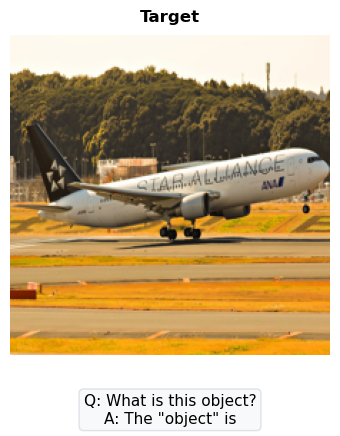

In [32]:
# --- Case 1: Zero-Shot Object Recognition ---
key = "plane_1" 
img = load_img(key)

if img:
    prompt = [
        img, 
        "Question: What is this object?\nAnswer:" 
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=5)
    visualize(prompt, prediction=output.strip(), title="Case 1: Zero-Shot VQA")

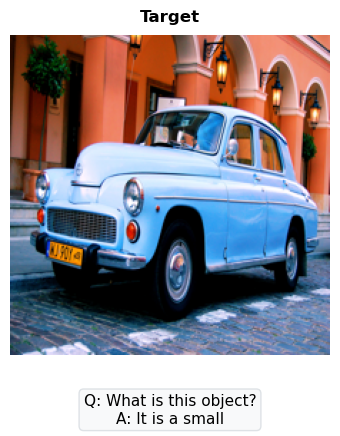

In [33]:
# --- Case 2: Zero-Shot Object Recognition ---
key = "car_1" 
img = load_img(key)

if img:
    prompt = [
        img, 
        "Question: What is this object?\nAnswer:" 
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=4)
    visualize(prompt, prediction=output.strip(), title="Case 1: Zero-Shot VQA")

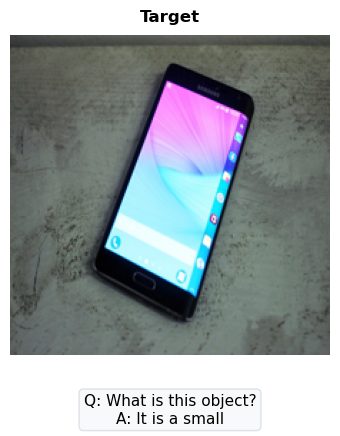

In [34]:
# --- Case 3: Zero-Shot Object Recognition ---
key = "phone_1" 
img = load_img(key)

if img:
    prompt = [
        img, 
        "Question: What is this object?\nAnswer:" 
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=4)
    visualize(prompt, prediction=output.strip(), title="Case 1: Zero-Shot VQA")

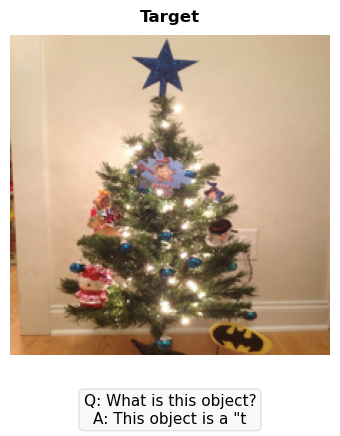

In [35]:
# --- Case 3: Zero-Shot Object Recognition ---
key = "tree" 
img = load_img(key)

if img:
    prompt = [
        img, 
        "Question: What is this object?\nAnswer:" 
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=6)
    visualize(prompt, prediction=output.strip(), title="Case 1: Zero-Shot VQA")


## 4. Test Case: Rapid Task Adaptation (Few-Shot VQA)
**Capability:** Evaluation of whether providing examples (shots) improves the model's response.
**Prompt Structure:** `[Img1] Q:.. A: Dog. [Img2] Q:.. A: Plane. [TargetImg] Q:.. A:`


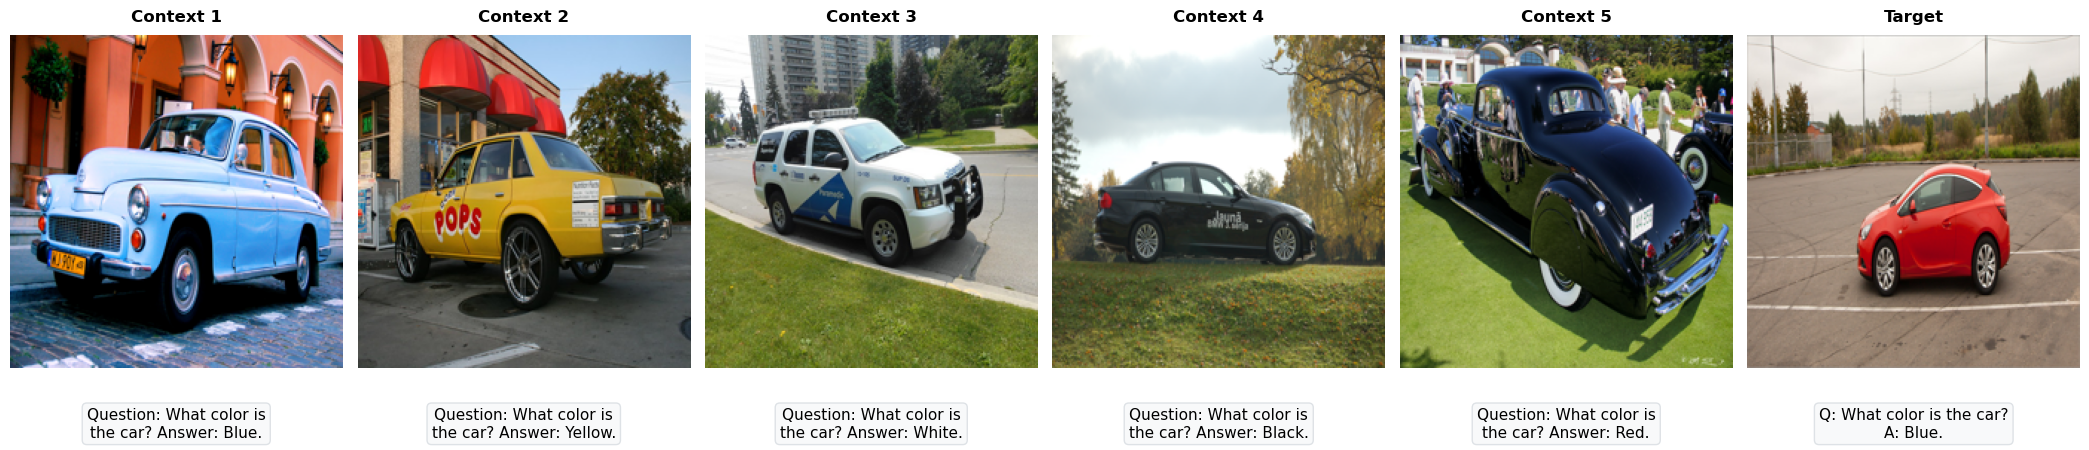

In [36]:
# --- Case 1: Few-Shot VQA (Rapid Adaptation) ---
# Support Set
img_s1 = load_img("car_1")
img_s2 = load_img("car_2")
img_s3 = load_img("car_3")
img_s4 = load_img("car_4")
img_s5 = load_img("car_6")
# Target
img_t = load_img("car_5")

if img_s1 and img_s2 and img_t:
    # FIX: Added "\n" at the end of each answer string to separate it from the NEXT image.
    # The paper relies on standard language modeling flow; a newline or space is critical.
    prompt = [
        # Support 1
        img_s1, "Question: What color is the car?\nAnswer: Blue.\n",
        
        # # Support 2
        img_s2, "Question: What color is the car?\nAnswer: Yellow.\n",
        
        # Support 3
        img_s3, "Question: What color is the car?\nAnswer: White.\n",
        
        # Support 4
        img_s4, "Question: What color is the car?\nAnswer: Black.\n",
        
        # Support 5
        img_s5, "Question: What color is the car?\nAnswer: Red.\n",
        
        # Target (Note: No trailing newline here, the model completes this line)
        img_t,  "Question: What color is the car?\nAnswer:"
    ]
    
    # Assuming generate_from_interleaved handles the stitching of tensors/text
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=3)
    visualize(prompt, prediction=output.strip(), title="Case 2: Few-Shot Adaptation")

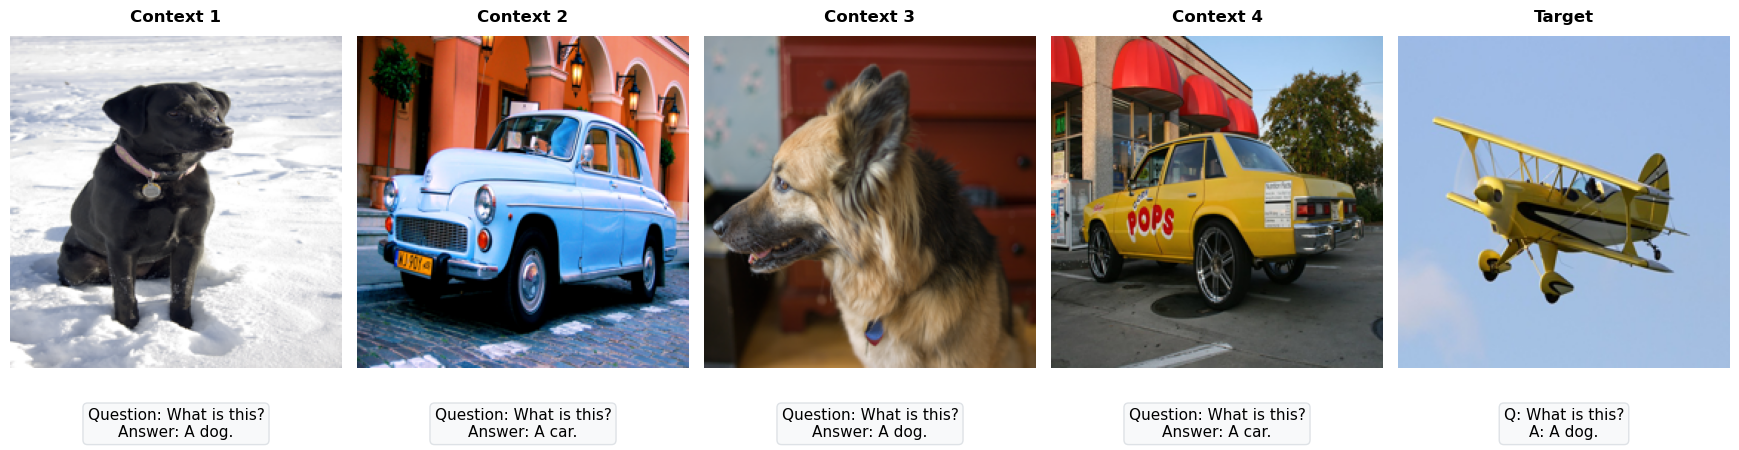

In [37]:
# --- Case 2: Few-Shot VQA (Rapid Adaptation) ---
# Support Set
img_s1 = load_img("dog_1")
img_s2 = load_img("car_1")
img_s3 = load_img("dog_2")
img_s4 = load_img("car_2")
# Target
img_t = load_img("plane_3")

if img_s1 and img_s2 and img_t:
    prompt = [
        # Support 1
        img_s1, "Question: What is this?\nAnswer: A dog.",
        img_s2, "Question: What is this?\nAnswer: A car.",
        
        # Support 2
        img_s3, "Question: What is this?\nAnswer: A dog.",
        img_s4, "Question: What is this?\nAnswer: A car.",
        # Target
        img_t,  "Question: What is this?\nAnswer:"
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=3)
    visualize(prompt, prediction=output.strip(), title="Case 2: Few-Shot Adaptation")


## 5. Test Case: Encyclopedic Knowledge
**Capability:** Testing if the model can retrieve external knowledge about the visual concept (e.g., identifying an inventor).
**Prompt:** `[Image] Question: Who invented this object? Answer:`


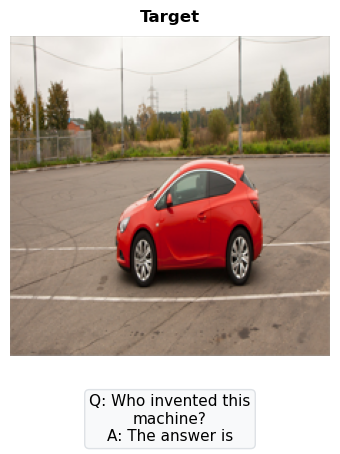

In [38]:
# --- Case 3: Encyclopedic Knowledge ---
key = "car_5" # Example: Asking about the inventor of the car (Benz/Ford)
img = load_img(key)

if img:
    prompt = [
        img, 
        "Question: Who invented this machine?\nAnswer:" 
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=3)
    visualize(prompt, prediction=output.strip(), title="Case 3: External Knowledge Retrieval")


## 6. Test Case: Fast Concept Binding (Nonsense Words)
**Capability:** Testing if the model can learn *new* associations in-context.
**Task:** We show it a cat and call it a "dax". We show it a dog and call it a "blicket". Then we show a new cat and see if it calls it a "dax".


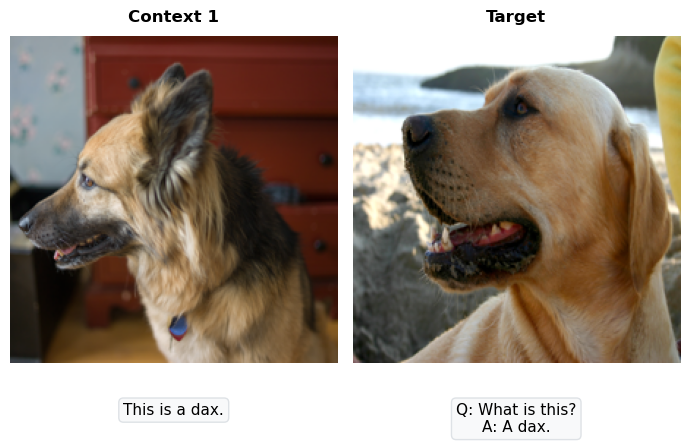

In [39]:
# --- Case 4: Concept Binding (Nonsense Words) ---
img_support = load_img("dog_2")
img_target = load_img("dog_3") # Different image of same class ideally

nonsense_word = "dax"

if img_support and img_target:
    prompt = [
        # Teach the model that this object is a "dax"
        img_support, f"\nThis is a {nonsense_word}.",
        
        # Ask it to identify the target using the new word
        img_target, "\nQuestion: What is this?\nAnswer:"
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=4)
    visualize(prompt, prediction=output.strip(), title="Case 4: Nonsense Word Binding")

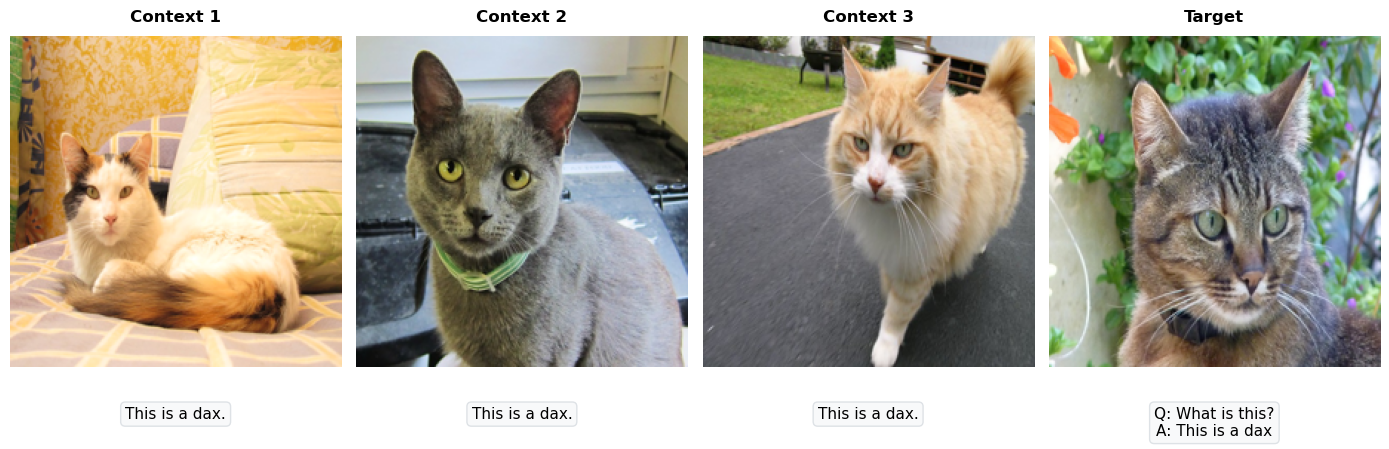

In [40]:
# --- Case 4: Concept Binding (Nonsense Words) ---
img_support = load_img("cat_1")
img_support2 = load_img("cat_2")
img_support3 = load_img("cat_3")
img_support4 = load_img("cat_4")
img_target = load_img("cat_5") # Different image of same class ideally

nonsense_word = "dax"

if img_support and img_target:
    prompt = [
        # Teach the model that this object is a "dax"
        img_support, f"This is a {nonsense_word}.",
        img_support2, f"This is a {nonsense_word}.",
        img_support3, f"This is a {nonsense_word}.",
        # img_support4, f"This is a {nonsense_word}.",
        
        # Ask it to identify the target using the new word
        img_target, "Question: What is this?\nAnswer:"
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=5)
    visualize(prompt, prediction=output.strip(), title="Case 4: Nonsense Word Binding")

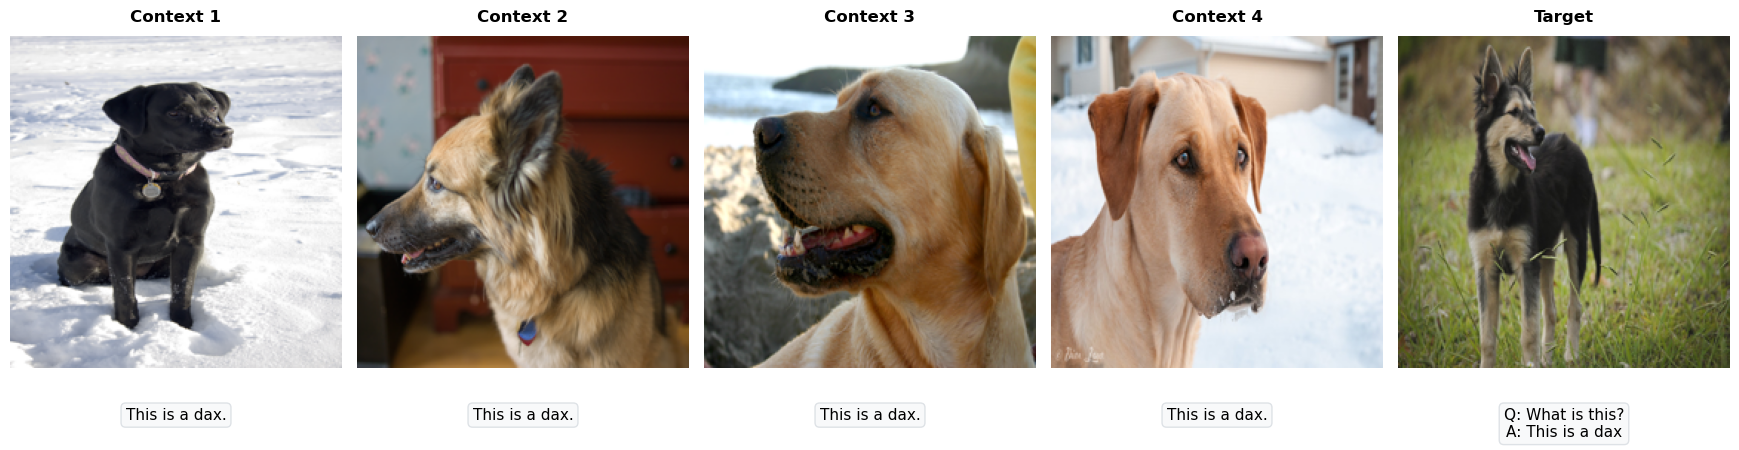

In [41]:
# --- Case 4: Concept Binding (Nonsense Words) ---
img_support = load_img("dog_1")
img_support2 = load_img("dog_2")
img_support3 = load_img("dog_3")
img_support4 = load_img("dog_5")
img_target = load_img("dog_4") # Different image of same class ideally

nonsense_word = "dax"

if img_support and img_target:
    prompt = [
        # Teach the model that this object is a "dax"
        img_support, f"This is a {nonsense_word}.",
        img_support2, f"This is a {nonsense_word}.",
        img_support3, f"This is a {nonsense_word}.",
        img_support4, f"This is a {nonsense_word}.",
        
        # Ask it to identify the target using the new word
        img_target, "Question: What is this?\nAnswer:"
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=5)
    visualize(prompt, prediction=output.strip(), title="Case 4: Nonsense Word Binding")

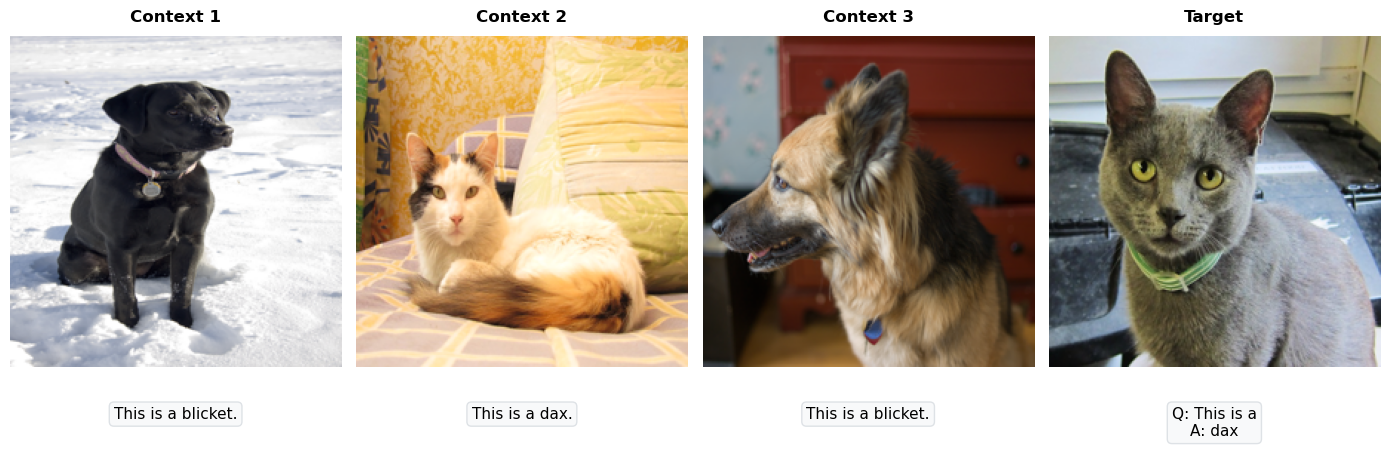

In [42]:
# --- Case 4: Fast Concept Binding (Nonsense Words) ---
# The goal: Bind a visual category (e.g., specific dog breed) to a new word ("dax").

# Support: Define the concepts
img_dog_1 = load_img("dog_1")
img_cat_1 = load_img("cat_1")
img_dog_2 = load_img("dog_2")

# Target: A new image of the same dog breed
img_target_dog = load_img("cat_2")

prompt = [
    # Teach that this visual category is a "dax"
    img_dog_1, "This is a blicket.\n",
    
    # Teach that this visual category is a "blicket"
    img_cat_1, "This is a dax.\n",
    
    # Reinforce "dax" with a different example (Inner-shot)
    img_dog_2, "This is a blicket.\n",
    
    # Target: The model must identify this as "dax" (not "dog")
    img_target_dog, "This is a" 
]

output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=2)
# Expected output: "dax."
visualize(prompt, prediction=output.strip(), title="Case 4: Concept Binding")

## 7. Test Case: Real-Name Binding (One-Shot Classification)
Capability: Testing if the model can perform standard classification after seeing just one labeled example. Task: Unlike "nonsense" words, here we use the actual class name. We show the model a Support Image of a lion and the text "This is a photo of a lion." We then show a Target Image (a different lion) and ask "Question: What animal is this?" to see if it successfully retrieves the label "lion" from the immediate context.

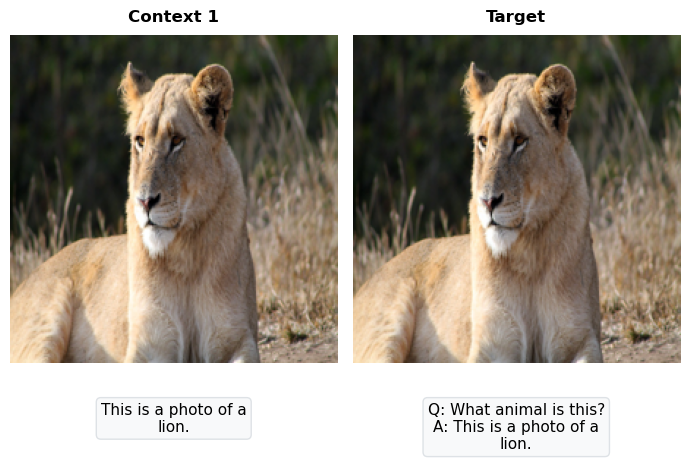

In [48]:
# --- Case 5: Real-Name Binding (One-Shot) ---
img_support = load_img("lion_1")
img_target = load_img("lion_1") 

if img_support and img_target:
    prompt = [
        # Support: Explicit labeling
        img_support, "This is a photo of a lion.",
        
        # Target: Ask for the name
        img_target, "Question: What animal is this?\nAnswer:"
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=8)
    visualize(prompt, prediction=output.strip(), title="Case 5: One-Shot Classification")

## 8. Test Case: Multimodal Reasoning (Deep Understanding)
Capability: Testing if the model can infer latent properties (like weight, material, or texture) that are defined purely by the context, rather than just visual appearance. Task: We provide a definition in the context: Image A (a car) is described as "Heavy". Image B (a phone) is described as "Light". We then present Image A again and ask: "Question: Is this object heavy or light?" The model must understand the property assignment from the support set to answer correctly, as "heavy" is not a visual class name but a concept bound to that image.

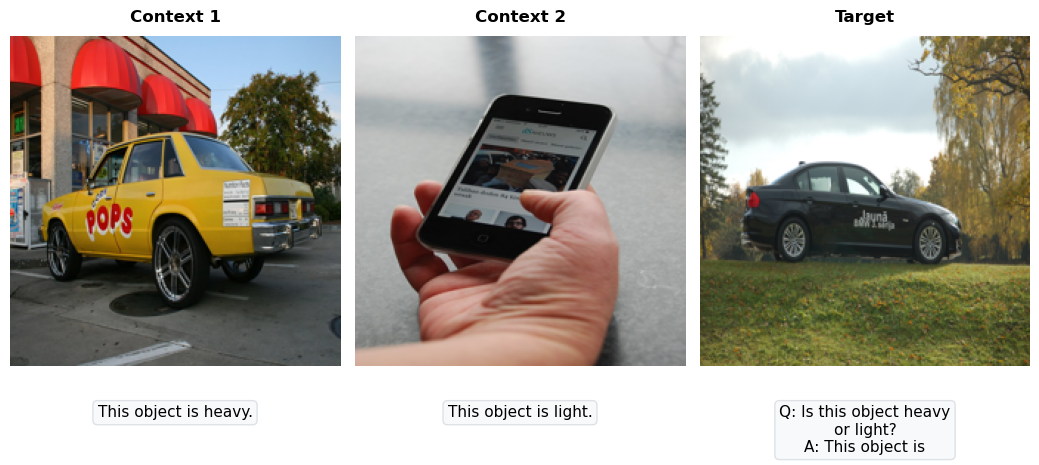

In [49]:
# --- Case 6: Multimodal Reasoning (Deep Understanding) ---
# We define properties for two objects and ask for a comparison
img_A = load_img("car_2")   # Define as "Heavy"
img_B = load_img("phone_3") # Define as "Light"
img_C = load_img("car_4") # Define as "Light"

if img_A and img_B:
    prompt = [
        img_A, "This object is heavy.",
        img_B, "This object is light.",
        img_C, "Question: Is this object heavy or light?\nAnswer:"
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=3)
    visualize(prompt, prediction=output.strip(), title="Case 6: Property Reasoning")

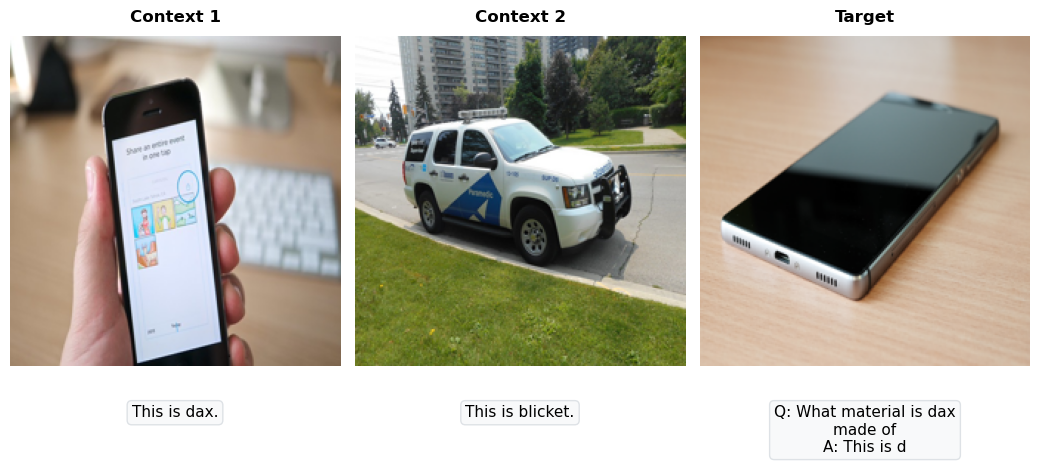

In [45]:
# --- Case 6: Multimodal Reasoning (Deep Understanding) ---
# We define properties for two objects and ask for a comparison
img_A = load_img("phone_2")   # Define as "Heavy"
img_B = load_img("car_3") # Define as "Light"
img_C = load_img("phone_4") # Define as "Light"

if img_A and img_B:
    prompt = [
        img_A, "This is dax.",
        img_B, "This is blicket.",
        img_C, "Question: What material is dax made of\nAnswer:"
    ]
    
    output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=3)
    visualize(prompt, prediction=output.strip(), title="Case 6: Property Reasoning")

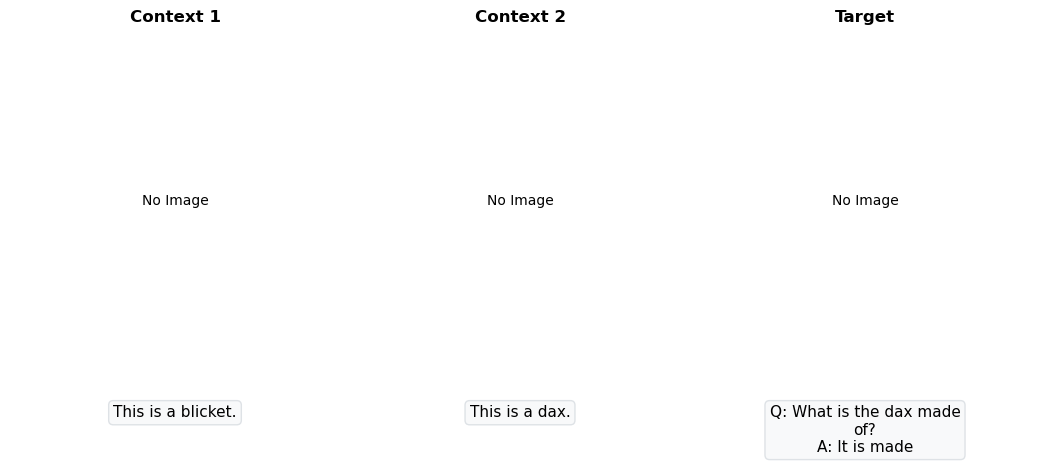

In [46]:
# --- Case 5: Fast-VQA (Reasoning with Learned Concepts) ---

# Definition Phase (Support)
img_def_vase  = load_img("vase_isolated")   # Define this as "blicket"
img_def_table = load_img("table_isolated")  # Define this as "dax"

# Question Phase (Target)
# A complex scene containing both a table and a vase
img_scene = load_img("room_scene_with_table_and_vase")

prompt = [
    # 1. Define the terms
    img_def_vase,  "This is a blicket.\n",
    img_def_table, "This is a dax.\n",
    
    # 2. Ask a question using the new terms
    # The model must look at the table (dax), not the vase (blicket).
    img_scene, "Question: What is the dax made of?\nAnswer:"
]

output = generate_from_interleaved(model, tokenizer, prompt, max_new_tokens=3)
# Expected output: "Wood" (describing the table)
visualize(prompt, prediction=output.strip(), title="Case 5: Fast-VQA")

In [47]:
import json
from pathlib import Path
from tqdm import tqdm

def filter_dataset(root_dir="../../conceptual_captions_data", split="train"):
    root_path = Path(root_dir)
    jsonl_path = root_path / f"{split}.jsonl"
    output_path = root_path / f"{split}_filtered.jsonl"
    
    # Ensure the input file exists
    if not jsonl_path.exists():
        print(f"Skipping {split}: {jsonl_path} not found.")
        return

    print(f"--- Processing '{split}' split ---")
    
    kept_count = 0
    total_count = 0
    
    with open(jsonl_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in tqdm(infile, desc=f"Checking {split} images"):
            total_count += 1
            try:
                entry = json.loads(line)
                # Check if the image file exists on disk
                image_path = root_path / entry['file_name']
                
                if image_path.exists():
                    outfile.write(line)
                    kept_count += 1
            except json.JSONDecodeError:
                continue

    print(f"Result for {split}:")
    print(f"  - Original entries: {total_count}")
    print(f"  - Valid images kept: {kept_count}")
    print(f"  - Filtered file saved to: {output_path}\n")

if __name__ == "__main__":
    # Run for validation first (it's faster)
    filter_dataset(split="validation")
    
    # Then run for train
    filter_dataset(split="train")

--- Processing 'validation' split ---


Checking validation images: 15840it [00:00, 72843.73it/s]


Result for validation:
  - Original entries: 15840
  - Valid images kept: 10601
  - Filtered file saved to: ../../conceptual_captions_data/validation_filtered.jsonl

--- Processing 'train' split ---


Checking train images: 3318333it [00:51, 64234.57it/s]


Result for train:
  - Original entries: 3318333
  - Valid images kept: 2167774
  - Filtered file saved to: ../../conceptual_captions_data/train_filtered.jsonl



In [54]:
import json
from pathlib import Path
from tqdm import tqdm
from PIL import Image

def filter_dataset(root_dir="../../conceptual_captions_data", split="train", 
                   validate_images=True):
    """
    Filter CC3M dataset to retain only valid image-caption pairs.
    
    Args:
        root_dir: Root directory containing JSONL and images
        split: 'train' or 'validation'
        validate_images: Whether to verify image can be opened
    """
    root_path = Path(root_dir)
    jsonl_path = root_path / f"{split}.jsonl"
    output_path = root_path / f"{split}_filtered.jsonl"
    
    if not jsonl_path.exists():
        print(f"Skipping {split}: {jsonl_path} not found.")
        return

    print(f"--- Processing '{split}' split ---")
    
    kept_count = 0
    total_count = 0
    failed_parse = 0
    failed_missing = 0
    failed_corrupt = 0
    
    with open(jsonl_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in tqdm(infile, desc=f"Filtering {split}"):
            total_count += 1
            
            # Parse JSON
            try:
                entry = json.loads(line)
            except json.JSONDecodeError:
                failed_parse += 1
                continue
            
            # Check file existence
            image_path = root_path / entry['file_name']
            if not image_path.exists():
                failed_missing += 1
                continue
            
            # Optional: Validate image can be opened
            if validate_images:
                try:
                    with Image.open(image_path) as img:
                        img.verify()  # Check if image is valid
                except Exception:
                    failed_corrupt += 1
                    continue
            
            outfile.write(line)
            kept_count += 1

    print(f"\nResults for {split}:")
    print(f"  Total entries:        {total_count}")
    print(f"  Valid pairs kept:     {kept_count} ({100*kept_count/total_count:.1f}%)")
    print(f"  Failed - JSON parse:  {failed_parse}")
    print(f"  Failed - missing:     {failed_missing}")
    print(f"  Failed - corrupt:     {failed_corrupt}")
    print(f"  Filtered file: {output_path}\n")
    
    return {
        'total': total_count,
        'kept': kept_count,
        'retention_rate': kept_count / total_count
    }

if __name__ == "__main__":
    val_stats = filter_dataset(split="validation", validate_images=True)
    train_stats = filter_dataset(split="train", validate_images=True)
    
    print("="*60)
    print(f"Final Dataset Statistics:")
    print(f"  Training:   {train_stats['kept']:,} samples")
    print(f"  Validation: {val_stats['kept']:,} samples")
    print(f"  Total:      {train_stats['kept'] + val_stats['kept']:,} samples")
    print("="*60)


--- Processing 'validation' split ---


Filtering validation: 15840it [00:01, 12587.22it/s]



Results for validation:
  Total entries:        15840
  Valid pairs kept:     10601 (66.9%)
  Failed - JSON parse:  0
  Failed - missing:     5239
  Failed - corrupt:     0
  Filtered file: ../../conceptual_captions_data/validation_filtered.jsonl

--- Processing 'train' split ---


Filtering train: 3318333it [10:20, 5345.31it/s]


Results for train:
  Total entries:        3318333
  Valid pairs kept:     2167774 (65.3%)
  Failed - JSON parse:  0
  Failed - missing:     1150559
  Failed - corrupt:     0
  Filtered file: ../../conceptual_captions_data/train_filtered.jsonl

Final Dataset Statistics:
  Training:   2,167,774 samples
  Validation: 10,601 samples
  Total:      2,178,375 samples
